In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch
from torch import nn
from IPython import display
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# define a set of image transformations to be applied during data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip the images horizontally
    transforms.RandomCrop(32, padding=4),  # randomly crop the images to 32x32 with 4 pixels of padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # randomly adjust brightness, contrast, saturation, and hue of the images
    transforms.ToTensor(), # convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize the pixel values to have mean 0.5 and standard deviation 0.5 in each channel
])
# define the batch size for training
batch_size=150

# load the CIFAR-10 training dataset, apply the defined transformations, and create a data loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          shuffle=True,batch_size=batch_size,num_workers=2)

# load the CIFAR-10 test dataset, apply the same transformations, and create a data loader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, batch_size=batch_size,num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 70690984.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=5,res=False):
        super(ConvBlock, self).__init__()

        # Define a ModuleList to store multiple convolution layers:
        self.conv_layers = nn.ModuleList()

        # Add k_size number of convolution layers to the ModuleList:
        for i in range(k_size):
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            # Initialize the weights of the convolution layer using xavier_normal:
            nn.init.xavier_normal_(conv_layer.weight, gain=nn.init.calculate_gain('relu'))
            self.conv_layers.append(conv_layer)

        # Define an adaptive average pooling layer:
        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Define a fully connected layer:
        self.fc_layer = nn.Linear(in_channels, k_size)
        nn.init.xavier_normal_(self.fc_layer.weight)
        
        # If extra connection is needed:
        self.extra_conv = None
        if res:
            # Define an extra convolution layer:
            self.extra_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            # Define a batch normalization layer:
            self.extra_bn = nn.BatchNorm2d(out_channels)
            # Initialize the weights of the convolution layer using xavier_normal:
            nn.init.xavier_normal_(self.extra_conv.weight, gain=nn.init.calculate_gain('relu'))
            

    def forward(self, x):
        # Get the batch size, number of channels, height and width of the input tensor:
        b, c, _, _ = x.size()
        # Apply adaptive average pooling to the input tensor:
        x_avg = self.avg_pooling(x)
        # Apply the fully connected layer to the output of adaptive average pooling:
        x_fc = self.fc_layer(x_avg.view(b, c))
        # Apply softmax activation to the output of fully connected layer, and reshape the tensor:
        x_fc = F.softmax(x_fc, dim=1).view(b, -1, 1, 1)
        # Initialize a variable to store the sum of output tensors of convolution layers:
        sum = 0
        for i, conv_layer in enumerate(self.conv_layers):
            # Multiply the output tensor of each convolution layer with corresponding element of x_fc, and add it to the sum:
            sum += x_fc[:, i:i+1] * conv_layer(x)
        
        # If residual connection is needed:
        extra_layer=None
        if self.extra_conv is not None:
            # Apply the extra convolution layer to the input tensor, and pass it through batch normalization layer:
            extra_layer = self.extra_bn(self.extra_conv(x))
            
            
        if extra_layer!=None:
          # Add the extra layer tensor to the sum tensor:
          sum += extra_layer
          
        return sum

In [4]:
class CIFAR10(nn.Module):
    def __init__(self):
        super(CIFAR10, self).__init__()

        # Define the backbone of the model
        self.block = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64, k_size=5,res=True), # Use a ConvBlock with residual connection
            nn.BatchNorm2d(64),                                           # Batch normalization layer
            nn.LeakyReLU(inplace=True),                                   # Leaky ReLU activation function
            ConvBlock(in_channels=64, out_channels=64, k_size=5,res=False), # Use a ConvBlock without residual connection
            nn.BatchNorm2d(64),                                             # Batch normalization layer
            nn.LeakyReLU(inplace=True),                                     # Leaky ReLU activation function
            nn.MaxPool2d(2, 2),                                             # Max pooling layer    
            ConvBlock(in_channels=64, out_channels=128, k_size=5,res=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=128, out_channels=128, k_size=5,res=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=128, out_channels=256, k_size=5,res=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            ConvBlock(in_channels=256, out_channels=256, k_size=5,res=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=256, out_channels=512, k_size=5,res=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=512, out_channels=512, k_size=5,res=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            ConvBlock(in_channels=512, out_channels=1024, k_size=5,res=True),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),
            ConvBlock(in_channels=1024, out_channels=1024, k_size=5,res=True),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Define the classifier as a sequence of layers
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1 using AdaptiveAvgPool
            nn.Flatten(),                  # Flatten the tensor into a 1D vector
            # defining a sequence for an MLP 
            nn.Linear(1024,512),           # Fully connected layer with 1024 inputs and 512 outputs
            nn.LeakyReLU(),                # Leaky ReLU activation function
            nn.Linear(512,10)              # Fully connected layer with 512 inputs and 10 outputs
                            
                       # Fully connected layer to produce the final class scores
        )

    # Define the forward pass of the model
    def forward(self, x):
        x = self.block(x)          # Pass the input through the backbone
        x = self.classifier(x)        # Pass the output of the backbone through the classifier
        return x

# Create an instance of the CIFAR10Model class
model = CIFAR10()



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
loss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=1e-6)

In [6]:

def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]  # Initialize a list with n zeros
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # Add arguments element-wise to self.data
    def reset(self):
        self.data = [0.0] * len(self.data) # Reset self.data to a list with len(self.data) zeros
    def __getitem__(self, idx):
        return self.data[idx] # Return the value at index idx of self.data

def evaluate_accuracy(net, data_iter,device): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        X,y=X.to(device), y.to(device) # Move data to the device
        metric.add(accuracy(net(X), y), y.numel()) # Add number of correct predictions and number of examples to metric
    if(metric[1]==0):
      return 0
    else:
      return metric[0] / metric[1] # Return accuracy as the ratio of correct predictions to total examples

def train_epoch_ch3(net, train_iter, loss, optimizer, device, batch_size=4, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for i, (images, labels) in enumerate(train_iter):
        X, y = images.to(device), labels.to(device)  # Move images and labels to the device
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y) # Compute loss between predicted and true labels
        optimizer.zero_grad() 
        l.backward() # Compute gradients
        optimizer.step() # Update parameters using gradients
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    if(metric[2]==0):
      return 0,0
    else:
      return metric[0] / metric[2], metric[1] / metric[2] 

Loss=[]
Train=[]
Test=[]
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer,device): 
    """Train a model."""
    for epoch in range(num_epochs):
        train_loss,train_acc = train_epoch_ch3(net, train_iter, loss, optimizer,device)
        test_acc = evaluate_accuracy(net, test_iter,device)
        #scheduler.step()
        print('Train metrics- Loss & Accuracy',train_loss,train_acc)
        print('Test Accuracy',test_acc)
        Loss.append(train_loss)
        Train.append(train_acc)
        Test.append(test_acc)
    

num_epochs = 40
train_ch3(model, trainloader, testloader, loss, num_epochs, optimizer,device)

Train metrics- Loss & Accuracy 1.990979495048523 0.23554
Test Accuracy 0.3282
Train metrics- Loss & Accuracy 1.612665225148201 0.39066
Test Accuracy 0.4723
Train metrics- Loss & Accuracy 1.2667465139627456 0.53692
Test Accuracy 0.601
Train metrics- Loss & Accuracy 1.0191015456318855 0.63806
Test Accuracy 0.6697
Train metrics- Loss & Accuracy 0.837932665526867 0.70764
Test Accuracy 0.7365
Train metrics- Loss & Accuracy 0.705518978357315 0.75626
Test Accuracy 0.7672
Train metrics- Loss & Accuracy 0.6142276260852814 0.78694
Test Accuracy 0.7927
Train metrics- Loss & Accuracy 0.556702157586813 0.80994
Test Accuracy 0.8108
Train metrics- Loss & Accuracy 0.5064155849516392 0.82666
Test Accuracy 0.812
Train metrics- Loss & Accuracy 0.46451448303461074 0.83998
Test Accuracy 0.8204
Train metrics- Loss & Accuracy 0.43175702169537544 0.85154
Test Accuracy 0.8399
Train metrics- Loss & Accuracy 0.3984688186943531 0.86138
Test Accuracy 0.8431
Train metrics- Loss & Accuracy 0.36986132645606995 0.8718

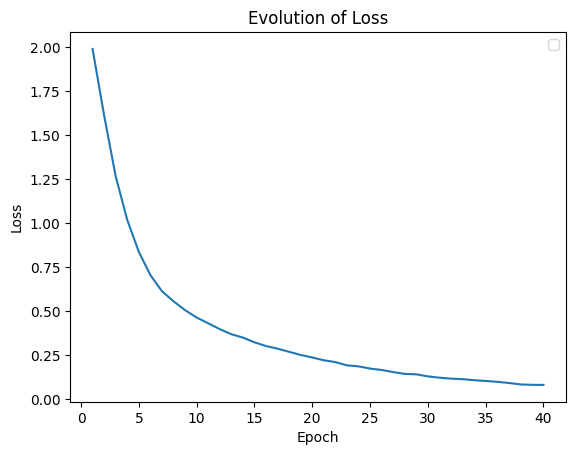

In [7]:
x=list(range(1,41))
plt.plot(x,Loss)
plt.title('Evolution of Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()
plt.show()

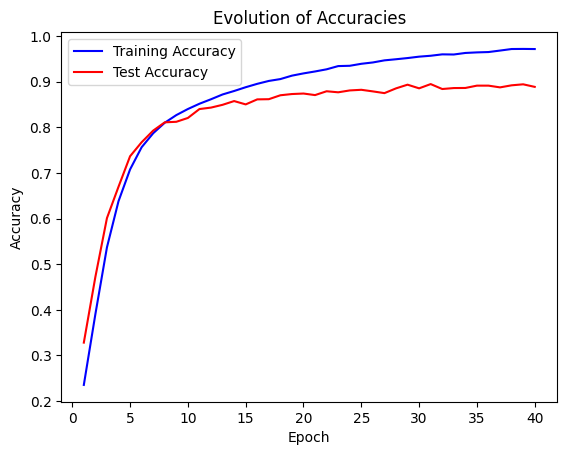

In [8]:
plt.plot(x, Train, color='blue', label='Training Accuracy')
plt.plot(x, Test, color='red', label='Test Accuracy')
plt.title('Evolution of Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')  
plt.legend()
plt.show()